In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 8.4.0-3ubuntu2) 8.4.0
Copyright (C) 2018 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMAction2 installation
import mmaction
print(mmaction.__version__)

# Check MMCV installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

import sys
# sys.path.append('/home/actrec/.local/lib/python3.6/site-packages/decord-0.5.3-py3.6-linux-x86_64.egg')
# import decord
import pickle

1.9.0 True
0.16.0
10.2
GCC 7.3


In [3]:
cd /home/robt427nv/childact/

/home/robt427nv/childact


# CSN age BOX

In [10]:
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/csn/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth \
      -O checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth

--2021-07-21 17:39:20--  https://download.openmmlab.com/mmaction/recognition/csn/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.25
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119580180 (114M) [application/octet-stream]
Saving to: ‘checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth’

checkpoints/ircsn_i 100%[===================>] 114,04M  6,78MB/s    in 17s     

2021-07-21 17:39:39 (6,87 MB/s) - ‘checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth’ saved [119580180/119580180]



In [6]:
from mmcv import Config
cfg = Config.fromfile('mmaction2/configs/recognition/csn/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb.py')

In [7]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
# cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'age-gender-3split-rgb-frames/'
cfg.data_root_val = 'age-gender-3split-rgb-frames/val/'
cfg.ann_file_train = 'age-gender-3split-rgb-frames/childact_train_rgb320_age_box.txt'
cfg.ann_file_val = 'age-gender-3split-rgb-frames/childact_val_rgb320_age_box.txt'
cfg.ann_file_test = 'age-gender-3split-rgb-frames/childact_test_rgb320_age_box.txt'

# cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'age-gender-3split-rgb-frames/childact_test_rgb320_age_box.txt'
cfg.data.test.data_prefix = 'age-gender-3split-rgb-frames/test/'

# cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'age-gender-3split-rgb-frames/childact_train_rgb320_age_box.txt'
cfg.data.train.data_prefix = 'age-gender-3split-rgb-frames/train/'

# cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'age-gender-3split-rgb-frames/childact_val_rgb320_age_box.txt'
cfg.data.val.data_prefix = 'age-gender-3split-rgb-frames/val/'

# cfg.data.test.modality = 'Flow'
# cfg.data.val.modality = 'Flow'
# cfg.data.train.modality = 'Flow'

# cfg.data.train.start_index = 0
# cfg.data.test.start_index = 0
# cfg.data.val.start_index = 0

cfg.data.test.filename_tmpl = '{:03}.jpeg'
cfg.data.train.filename_tmpl = '{:03}.jpeg'
cfg.data.val.filename_tmpl = '{:03}.jpeg'
# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 6
# We can use the pre-trained TSN model
cfg.load_from = 'checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth'
# cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/CSN-age-box'

cfg.total_epochs = 50

# cfg.momentum_config = dict(
#     policy='cyclic',
#     target_ratio=(0.85 / 0.95, 1),
#     cyclic_times=1,
#     step_ratio_up=0.4,
# )

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 20
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 100

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

cfg.data.videos_per_gpu=4

# cfg.model.backbone.in_channels = 2

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
# del cfg.optimizer['momentum']
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet3dCSN',
        pretrained2d=False,
        pretrained=
        'https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r152_ig65m_20200807-771c4135.pth',
        depth=152,
        with_pool2=False,
        bottleneck_mode='ir',
        norm_eval=True,
        zero_init_residual=False,
        bn_frozen=True),
    cls_head=dict(
        type='I3DHead',
        num_classes=6,
        in_channels=2048,
        spatial_type='avg',
        dropout_ratio=0.5,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
checkpoint_config = dict(interval=20)
log_config = dict(interval=100, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = 'checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth'
resume_from = None
workflow = [('train', 1)]
dataset_type = 'RawframeDataset

In [8]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
# CUDA_LAUNCH_BLOCKING=1
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-08-10 08:19:33,116 - mmaction - INFO - load model from: https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r152_ig65m_20200807-771c4135.pth
2021-08-10 08:19:33,117 - mmaction - INFO - Use load_from_http loader
2021-08-10 08:19:35,230 - mmaction - INFO - load checkpoint from checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth
2021-08-10 08:19:35,231 - mmaction - INFO - Use load_from_local loader
2021-08-10 08:19:35,407 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 2048]) from checkpoint, the shape in current model is torch.Size([6, 2048]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([6]).
2021-08-10 08:19:35,411 - mmaction - INFO - Start running, host: robt427nv@robt427NV, work_dir: /home/robt427nv/ch

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 11/11, 9.7 task/s, elapsed: 1s, ETA:     0s

2021-08-10 08:21:45,103 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 08:21:45,105 - mmaction - INFO - 
top1_acc	0.2727
top5_acc	1.0000
2021-08-10 08:21:45,105 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 08:21:45,107 - mmaction - INFO - 
mean_acc	0.2500
2021-08-10 08:21:45,432 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-08-10 08:21:45,433 - mmaction - INFO - Best top1_acc is 0.2727 at 5 epoch.
2021-08-10 08:21:45,433 - mmaction - INFO - Epoch(val) [5][3]	top1_acc: 0.2727, top5_acc: 1.0000, mean_class_accuracy: 0.2500


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 11/11, 9.0 task/s, elapsed: 1s, ETA:     0s

2021-08-10 08:23:56,335 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 08:23:56,337 - mmaction - INFO - 
top1_acc	0.1818
top5_acc	1.0000
2021-08-10 08:23:56,337 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 08:23:56,338 - mmaction - INFO - 
mean_acc	0.1667
2021-08-10 08:23:56,338 - mmaction - INFO - Epoch(val) [10][3]	top1_acc: 0.1818, top5_acc: 1.0000, mean_class_accuracy: 0.1667


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 11/11, 9.7 task/s, elapsed: 1s, ETA:     0s

2021-08-10 08:26:01,773 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 08:26:01,775 - mmaction - INFO - 
top1_acc	0.2727
top5_acc	1.0000
2021-08-10 08:26:01,775 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 08:26:01,777 - mmaction - INFO - 
mean_acc	0.2500
2021-08-10 08:26:01,777 - mmaction - INFO - Epoch(val) [15][3]	top1_acc: 0.2727, top5_acc: 1.0000, mean_class_accuracy: 0.2500
2021-08-10 08:28:08,388 - mmaction - INFO - Saving checkpoint at 20 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 11/11, 9.5 task/s, elapsed: 1s, ETA:     0s

2021-08-10 08:28:09,906 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 08:28:09,907 - mmaction - INFO - 
top1_acc	0.1818
top5_acc	1.0000
2021-08-10 08:28:09,908 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 08:28:09,909 - mmaction - INFO - 
mean_acc	0.1333
2021-08-10 08:28:09,909 - mmaction - INFO - Epoch(val) [20][3]	top1_acc: 0.1818, top5_acc: 1.0000, mean_class_accuracy: 0.1333


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 11/11, 9.1 task/s, elapsed: 1s, ETA:     0s

2021-08-10 08:30:15,204 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 08:30:15,206 - mmaction - INFO - 
top1_acc	0.2727
top5_acc	1.0000
2021-08-10 08:30:15,207 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 08:30:15,208 - mmaction - INFO - 
mean_acc	0.1833
2021-08-10 08:30:15,209 - mmaction - INFO - Epoch(val) [25][3]	top1_acc: 0.2727, top5_acc: 1.0000, mean_class_accuracy: 0.1833


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 11/11, 9.6 task/s, elapsed: 1s, ETA:     0s

2021-08-10 08:32:21,612 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 08:32:21,614 - mmaction - INFO - 
top1_acc	0.3636
top5_acc	1.0000
2021-08-10 08:32:21,615 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 08:32:21,617 - mmaction - INFO - 
mean_acc	0.3125
2021-08-10 08:32:21,940 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_30.pth.
2021-08-10 08:32:21,941 - mmaction - INFO - Best top1_acc is 0.3636 at 30 epoch.
2021-08-10 08:32:21,942 - mmaction - INFO - Epoch(val) [30][3]	top1_acc: 0.3636, top5_acc: 1.0000, mean_class_accuracy: 0.3125


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 11/11, 9.6 task/s, elapsed: 1s, ETA:     0s

2021-08-10 08:34:28,553 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 08:34:28,554 - mmaction - INFO - 
top1_acc	0.2727
top5_acc	1.0000
2021-08-10 08:34:28,555 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 08:34:28,555 - mmaction - INFO - 
mean_acc	0.1833
2021-08-10 08:34:28,556 - mmaction - INFO - Epoch(val) [35][3]	top1_acc: 0.2727, top5_acc: 1.0000, mean_class_accuracy: 0.1833
2021-08-10 08:36:37,867 - mmaction - INFO - Saving checkpoint at 40 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 11/11, 9.3 task/s, elapsed: 1s, ETA:     0s

2021-08-10 08:36:39,421 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 08:36:39,423 - mmaction - INFO - 
top1_acc	0.2727
top5_acc	1.0000
2021-08-10 08:36:39,423 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 08:36:39,424 - mmaction - INFO - 
mean_acc	0.1833
2021-08-10 08:36:39,426 - mmaction - INFO - Epoch(val) [40][3]	top1_acc: 0.2727, top5_acc: 1.0000, mean_class_accuracy: 0.1833


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 11/11, 9.1 task/s, elapsed: 1s, ETA:     0s

2021-08-10 08:38:50,814 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 08:38:50,816 - mmaction - INFO - 
top1_acc	0.2727
top5_acc	1.0000
2021-08-10 08:38:50,817 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 08:38:50,819 - mmaction - INFO - 
mean_acc	0.1833
2021-08-10 08:38:50,820 - mmaction - INFO - Epoch(val) [45][3]	top1_acc: 0.2727, top5_acc: 1.0000, mean_class_accuracy: 0.1833
2021-08-10 08:41:01,028 - mmaction - INFO - Saving checkpoint at 50 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 11/11, 9.5 task/s, elapsed: 1s, ETA:     0s

2021-08-10 08:41:02,547 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 08:41:02,549 - mmaction - INFO - 
top1_acc	0.1818
top5_acc	1.0000
2021-08-10 08:41:02,550 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 08:41:02,553 - mmaction - INFO - 
mean_acc	0.1333
2021-08-10 08:41:02,554 - mmaction - INFO - Epoch(val) [50][3]	top1_acc: 0.1818, top5_acc: 1.0000, mean_class_accuracy: 0.1333


In [9]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

In [10]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
# from mmaction.models import build_model
# from mmaction.datasets import build_dataset

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=1,
        workers_per_gpu=2,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 8/8, 0.4 task/s, elapsed: 18s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.0000
top5_acc	0.8750

Evaluating mean_class_accuracy ...

mean_acc	0.0000
top1_acc: 0.0000
top5_acc: 0.8750
mean_class_accuracy: 0.0000


<AxesSubplot:>

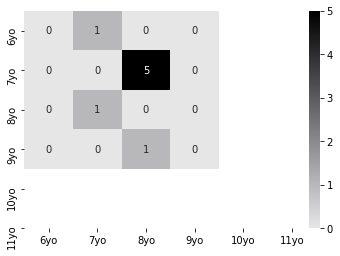

In [12]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
# /np.sum(cf_mat), fmt='.2%',
sns.heatmap(cf_mat, cmap=cmap, annot=True, xticklabels = ['6yo', '7yo', '8yo', '9yo', '10yo', '11yo'], yticklabels = ['6yo', '7yo', '8yo', '9yo', '10yo', '11yo'])

In [11]:
mean_error = (1+5+1+1)/8 #number of all tested videos
print(mean_error)

1.0


# CSN age clap 

In [4]:
from mmcv import Config
cfg = Config.fromfile('mmaction2/configs/recognition/csn/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb.py')

In [5]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
# cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'age-gender-3split-rgb-frames/'
cfg.data_root_val = 'age-gender-3split-rgb-frames/val/'
cfg.ann_file_train = 'age-gender-3split-rgb-frames/childact_train_rgb320_age_clap.txt'
cfg.ann_file_val = 'age-gender-3split-rgb-frames/childact_val_rgb320_age_clap.txt'
cfg.ann_file_test = 'age-gender-3split-rgb-frames/childact_test_rgb320_age_clap.txt'

# cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'age-gender-3split-rgb-frames/childact_test_rgb320_age_clap.txt'
cfg.data.test.data_prefix = 'age-gender-3split-rgb-frames/test/'

# cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'age-gender-3split-rgb-frames/childact_train_rgb320_age_clap.txt'
cfg.data.train.data_prefix = 'age-gender-3split-rgb-frames/train/'

# cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'age-gender-3split-rgb-frames/childact_val_rgb320_age_clap.txt'
cfg.data.val.data_prefix = 'age-gender-3split-rgb-frames/val/'

# cfg.data.test.modality = 'Flow'
# cfg.data.val.modality = 'Flow'
# cfg.data.train.modality = 'Flow'

# cfg.data.train.start_index = 0
# cfg.data.test.start_index = 0
# cfg.data.val.start_index = 0

cfg.data.test.filename_tmpl = '{:03}.jpeg'
cfg.data.train.filename_tmpl = '{:03}.jpeg'
cfg.data.val.filename_tmpl = '{:03}.jpeg'
# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 6
# We can use the pre-trained TSN model
cfg.load_from = 'checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth'
# cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/CSN-age-box'

cfg.total_epochs = 50

# cfg.momentum_config = dict(
#     policy='cyclic',
#     target_ratio=(0.85 / 0.95, 1),
#     cyclic_times=1,
#     step_ratio_up=0.4,
# )

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 20
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 100

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

cfg.data.videos_per_gpu=4

# cfg.model.backbone.in_channels = 2

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
# del cfg.optimizer['momentum']
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet3dCSN',
        pretrained2d=False,
        pretrained=
        'https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r152_ig65m_20200807-771c4135.pth',
        depth=152,
        with_pool2=False,
        bottleneck_mode='ir',
        norm_eval=True,
        zero_init_residual=False,
        bn_frozen=True),
    cls_head=dict(
        type='I3DHead',
        num_classes=6,
        in_channels=2048,
        spatial_type='avg',
        dropout_ratio=0.5,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
checkpoint_config = dict(interval=20)
log_config = dict(interval=100, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = 'checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth'
resume_from = None
workflow = [('train', 1)]
dataset_type = 'RawframeDataset

In [6]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
# CUDA_LAUNCH_BLOCKING=1
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-08-10 08:52:09,598 - mmaction - INFO - load model from: https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r152_ig65m_20200807-771c4135.pth
2021-08-10 08:52:09,599 - mmaction - INFO - Use load_from_http loader
2021-08-10 08:52:11,641 - mmaction - INFO - load checkpoint from checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth
2021-08-10 08:52:11,642 - mmaction - INFO - Use load_from_local loader
2021-08-10 08:52:11,809 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 2048]) from checkpoint, the shape in current model is torch.Size([6, 2048]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([6]).
2021-08-10 08:52:11,815 - mmaction - INFO - Start running, host: robt427nv@robt427NV, work_dir: /home/robt427nv/ch

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 14/14, 9.8 task/s, elapsed: 1s, ETA:     0s

2021-08-10 08:54:38,069 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 08:54:38,070 - mmaction - INFO - 
top1_acc	0.2143
top5_acc	0.9286
2021-08-10 08:54:38,071 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 08:54:38,073 - mmaction - INFO - 
mean_acc	0.1905
2021-08-10 08:54:38,394 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-08-10 08:54:38,396 - mmaction - INFO - Best top1_acc is 0.2143 at 5 epoch.
2021-08-10 08:54:38,396 - mmaction - INFO - Epoch(val) [5][4]	top1_acc: 0.2143, top5_acc: 0.9286, mean_class_accuracy: 0.1905


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 14/14, 9.8 task/s, elapsed: 1s, ETA:     0s

2021-08-10 08:57:05,509 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 08:57:05,511 - mmaction - INFO - 
top1_acc	0.5000
top5_acc	0.9286
2021-08-10 08:57:05,511 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 08:57:05,512 - mmaction - INFO - 
mean_acc	0.1667
2021-08-10 08:57:05,849 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2021-08-10 08:57:05,850 - mmaction - INFO - Best top1_acc is 0.5000 at 10 epoch.
2021-08-10 08:57:05,851 - mmaction - INFO - Epoch(val) [10][4]	top1_acc: 0.5000, top5_acc: 0.9286, mean_class_accuracy: 0.1667


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 14/14, 10.0 task/s, elapsed: 1s, ETA:     0s

2021-08-10 08:59:33,436 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 08:59:33,438 - mmaction - INFO - 
top1_acc	0.4286
top5_acc	0.9286
2021-08-10 08:59:33,439 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 08:59:33,441 - mmaction - INFO - 
mean_acc	0.2857
2021-08-10 08:59:33,442 - mmaction - INFO - Epoch(val) [15][4]	top1_acc: 0.4286, top5_acc: 0.9286, mean_class_accuracy: 0.2857
2021-08-10 09:01:59,151 - mmaction - INFO - Saving checkpoint at 20 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 14/14, 10.5 task/s, elapsed: 1s, ETA:     0s

2021-08-10 09:02:00,960 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 09:02:00,962 - mmaction - INFO - 
top1_acc	0.5000
top5_acc	0.8571
2021-08-10 09:02:00,963 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 09:02:00,964 - mmaction - INFO - 
mean_acc	0.4286
2021-08-10 09:02:00,965 - mmaction - INFO - Epoch(val) [20][4]	top1_acc: 0.5000, top5_acc: 0.8571, mean_class_accuracy: 0.4286


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 14/14, 10.6 task/s, elapsed: 1s, ETA:     0s

2021-08-10 09:04:28,396 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 09:04:28,398 - mmaction - INFO - 
top1_acc	0.3571
top5_acc	0.9286
2021-08-10 09:04:28,398 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 09:04:28,399 - mmaction - INFO - 
mean_acc	0.3214
2021-08-10 09:04:28,399 - mmaction - INFO - Epoch(val) [25][4]	top1_acc: 0.3571, top5_acc: 0.9286, mean_class_accuracy: 0.3214


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 14/14, 10.2 task/s, elapsed: 1s, ETA:     0s

2021-08-10 09:06:55,330 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 09:06:55,331 - mmaction - INFO - 
top1_acc	0.3571
top5_acc	0.9286
2021-08-10 09:06:55,332 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 09:06:55,333 - mmaction - INFO - 
mean_acc	0.3810
2021-08-10 09:06:55,334 - mmaction - INFO - Epoch(val) [30][4]	top1_acc: 0.3571, top5_acc: 0.9286, mean_class_accuracy: 0.3810


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 14/14, 10.1 task/s, elapsed: 1s, ETA:     0s

2021-08-10 09:09:21,996 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 09:09:21,998 - mmaction - INFO - 
top1_acc	0.3571
top5_acc	0.9286
2021-08-10 09:09:21,998 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 09:09:22,000 - mmaction - INFO - 
mean_acc	0.3214
2021-08-10 09:09:22,001 - mmaction - INFO - Epoch(val) [35][4]	top1_acc: 0.3571, top5_acc: 0.9286, mean_class_accuracy: 0.3214
2021-08-10 09:11:48,431 - mmaction - INFO - Saving checkpoint at 40 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 14/14, 10.0 task/s, elapsed: 1s, ETA:     0s

2021-08-10 09:11:50,333 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 09:11:50,334 - mmaction - INFO - 
top1_acc	0.2857
top5_acc	0.9286
2021-08-10 09:11:50,335 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 09:11:50,336 - mmaction - INFO - 
mean_acc	0.2976
2021-08-10 09:11:50,336 - mmaction - INFO - Epoch(val) [40][4]	top1_acc: 0.2857, top5_acc: 0.9286, mean_class_accuracy: 0.2976


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 14/14, 10.1 task/s, elapsed: 1s, ETA:     0s

2021-08-10 09:14:17,482 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 09:14:17,483 - mmaction - INFO - 
top1_acc	0.3571
top5_acc	0.9286
2021-08-10 09:14:17,483 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 09:14:17,484 - mmaction - INFO - 
mean_acc	0.3810
2021-08-10 09:14:17,484 - mmaction - INFO - Epoch(val) [45][4]	top1_acc: 0.3571, top5_acc: 0.9286, mean_class_accuracy: 0.3810
2021-08-10 09:16:43,161 - mmaction - INFO - Saving checkpoint at 50 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 14/14, 10.0 task/s, elapsed: 1s, ETA:     0s

2021-08-10 09:16:45,035 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 09:16:45,037 - mmaction - INFO - 
top1_acc	0.3571
top5_acc	0.9286
2021-08-10 09:16:45,037 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 09:16:45,038 - mmaction - INFO - 
mean_acc	0.3810
2021-08-10 09:16:45,039 - mmaction - INFO - Epoch(val) [50][4]	top1_acc: 0.3571, top5_acc: 0.9286, mean_class_accuracy: 0.3810


In [7]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

In [8]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
# from mmaction.models import build_model
# from mmaction.datasets import build_dataset

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=1,
        workers_per_gpu=2,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 18/18, 0.6 task/s, elapsed: 29s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5000
top5_acc	0.9444

Evaluating mean_class_accuracy ...

mean_acc	0.2569
top1_acc: 0.5000
top5_acc: 0.9444
mean_class_accuracy: 0.2569


<AxesSubplot:>

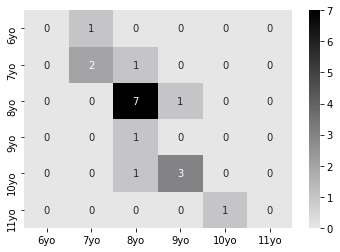

In [9]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
# /np.sum(cf_mat), fmt='.2%',
sns.heatmap(cf_mat, cmap=cmap, annot=True, xticklabels = ['6yo', '7yo', '8yo', '9yo', '10yo', '11yo'], yticklabels = ['6yo', '7yo', '8yo', '9yo', '10yo', '11yo'])

In [10]:
mean_error = (1+1+1+1+3+1+1)/18 #number of all tested videos
print(mean_error)

0.5


# CSN age go 

In [4]:
from mmcv import Config
cfg = Config.fromfile('mmaction2/configs/recognition/csn/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb.py')

In [5]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
# cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'age-gender-3split-rgb-frames/'
cfg.data_root_val = 'age-gender-3split-rgb-frames/val/'
cfg.ann_file_train = 'age-gender-3split-rgb-frames/childact_train_rgb320_age_go.txt'
cfg.ann_file_val = 'age-gender-3split-rgb-frames/childact_val_rgb320_age_go.txt'
cfg.ann_file_test = 'age-gender-3split-rgb-frames/childact_test_rgb320_age_go.txt'

# cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'age-gender-3split-rgb-frames/childact_test_rgb320_age_go.txt'
cfg.data.test.data_prefix = 'age-gender-3split-rgb-frames/test/'

# cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'age-gender-3split-rgb-frames/childact_train_rgb320_age_go.txt'
cfg.data.train.data_prefix = 'age-gender-3split-rgb-frames/train/'

# cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'age-gender-3split-rgb-frames/childact_val_rgb320_age_go.txt'
cfg.data.val.data_prefix = 'age-gender-3split-rgb-frames/val/'

# cfg.data.test.modality = 'Flow'
# cfg.data.val.modality = 'Flow'
# cfg.data.train.modality = 'Flow'

# cfg.data.train.start_index = 0
# cfg.data.test.start_index = 0
# cfg.data.val.start_index = 0

cfg.data.test.filename_tmpl = '{:03}.jpeg'
cfg.data.train.filename_tmpl = '{:03}.jpeg'
cfg.data.val.filename_tmpl = '{:03}.jpeg'
# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 6
# We can use the pre-trained TSN model
cfg.load_from = 'checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth'
# cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/CSN-age-go'

cfg.total_epochs = 50

# cfg.momentum_config = dict(
#     policy='cyclic',
#     target_ratio=(0.85 / 0.95, 1),
#     cyclic_times=1,
#     step_ratio_up=0.4,
# )

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 20
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 100

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

cfg.data.videos_per_gpu=4

# cfg.model.backbone.in_channels = 2

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
# del cfg.optimizer['momentum']
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet3dCSN',
        pretrained2d=False,
        pretrained=
        'https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r152_ig65m_20200807-771c4135.pth',
        depth=152,
        with_pool2=False,
        bottleneck_mode='ir',
        norm_eval=True,
        zero_init_residual=False,
        bn_frozen=True),
    cls_head=dict(
        type='I3DHead',
        num_classes=6,
        in_channels=2048,
        spatial_type='avg',
        dropout_ratio=0.5,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
checkpoint_config = dict(interval=20)
log_config = dict(interval=100, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = 'checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth'
resume_from = None
workflow = [('train', 1)]
dataset_type = 'RawframeDataset

In [17]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
# CUDA_LAUNCH_BLOCKING=1
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-08-10 09:40:44,136 - mmaction - INFO - load model from: https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r152_ig65m_20200807-771c4135.pth
2021-08-10 09:40:44,137 - mmaction - INFO - Use load_from_http loader
2021-08-10 09:40:44,381 - mmaction - INFO - load checkpoint from checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth
2021-08-10 09:40:44,382 - mmaction - INFO - Use load_from_local loader
2021-08-10 09:40:44,546 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 2048]) from checkpoint, the shape in current model is torch.Size([6, 2048]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([6]).
2021-08-10 09:40:44,549 - mmaction - INFO - Start running, host: robt427nv@robt427NV, work_dir: /home/robt427nv/ch

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 18/18, 10.1 task/s, elapsed: 2s, ETA:     0s

2021-08-10 09:42:50,544 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 09:42:50,545 - mmaction - INFO - 
top1_acc	0.3889
top5_acc	1.0000
2021-08-10 09:42:50,546 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 09:42:50,547 - mmaction - INFO - 
mean_acc	0.2500
2021-08-10 09:42:50,846 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-08-10 09:42:50,847 - mmaction - INFO - Best top1_acc is 0.3889 at 5 epoch.
2021-08-10 09:42:50,848 - mmaction - INFO - Epoch(val) [5][5]	top1_acc: 0.3889, top5_acc: 1.0000, mean_class_accuracy: 0.2500


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 18/18, 10.3 task/s, elapsed: 2s, ETA:     0s

2021-08-10 09:44:57,985 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 09:44:57,988 - mmaction - INFO - 
top1_acc	0.5000
top5_acc	1.0000
2021-08-10 09:44:57,988 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 09:44:57,990 - mmaction - INFO - 
mean_acc	0.3000
2021-08-10 09:44:58,325 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2021-08-10 09:44:58,326 - mmaction - INFO - Best top1_acc is 0.5000 at 10 epoch.
2021-08-10 09:44:58,327 - mmaction - INFO - Epoch(val) [10][5]	top1_acc: 0.5000, top5_acc: 1.0000, mean_class_accuracy: 0.3000


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 18/18, 10.7 task/s, elapsed: 2s, ETA:     0s

2021-08-10 09:47:05,944 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 09:47:05,946 - mmaction - INFO - 
top1_acc	0.6111
top5_acc	1.0000
2021-08-10 09:47:05,946 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 09:47:05,948 - mmaction - INFO - 
mean_acc	0.4550
2021-08-10 09:47:06,291 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_15.pth.
2021-08-10 09:47:06,292 - mmaction - INFO - Best top1_acc is 0.6111 at 15 epoch.
2021-08-10 09:47:06,293 - mmaction - INFO - Epoch(val) [15][5]	top1_acc: 0.6111, top5_acc: 1.0000, mean_class_accuracy: 0.4550
2021-08-10 09:49:12,101 - mmaction - INFO - Saving checkpoint at 20 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 18/18, 10.9 task/s, elapsed: 2s, ETA:     0s

2021-08-10 09:49:14,144 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 09:49:14,146 - mmaction - INFO - 
top1_acc	0.4444
top5_acc	1.0000
2021-08-10 09:49:14,146 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 09:49:14,147 - mmaction - INFO - 
mean_acc	0.2300
2021-08-10 09:49:14,147 - mmaction - INFO - Epoch(val) [20][5]	top1_acc: 0.4444, top5_acc: 1.0000, mean_class_accuracy: 0.2300


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 18/18, 10.3 task/s, elapsed: 2s, ETA:     0s

2021-08-10 09:51:21,538 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 09:51:21,539 - mmaction - INFO - 
top1_acc	0.6667
top5_acc	1.0000
2021-08-10 09:51:21,539 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 09:51:21,540 - mmaction - INFO - 
mean_acc	0.5100
2021-08-10 09:51:21,858 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_25.pth.
2021-08-10 09:51:21,859 - mmaction - INFO - Best top1_acc is 0.6667 at 25 epoch.
2021-08-10 09:51:21,860 - mmaction - INFO - Epoch(val) [25][5]	top1_acc: 0.6667, top5_acc: 1.0000, mean_class_accuracy: 0.5100


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 18/18, 10.7 task/s, elapsed: 2s, ETA:     0s

2021-08-10 09:53:29,780 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 09:53:29,782 - mmaction - INFO - 
top1_acc	0.3333
top5_acc	1.0000
2021-08-10 09:53:29,783 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 09:53:29,784 - mmaction - INFO - 
mean_acc	0.2250
2021-08-10 09:53:29,785 - mmaction - INFO - Epoch(val) [30][5]	top1_acc: 0.3333, top5_acc: 1.0000, mean_class_accuracy: 0.2250


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 18/18, 10.5 task/s, elapsed: 2s, ETA:     0s

2021-08-10 09:55:37,088 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 09:55:37,090 - mmaction - INFO - 
top1_acc	0.6667
top5_acc	1.0000
2021-08-10 09:55:37,090 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 09:55:37,091 - mmaction - INFO - 
mean_acc	0.6450
2021-08-10 09:55:37,092 - mmaction - INFO - Epoch(val) [35][5]	top1_acc: 0.6667, top5_acc: 1.0000, mean_class_accuracy: 0.6450
2021-08-10 09:57:42,632 - mmaction - INFO - Saving checkpoint at 40 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 18/18, 10.6 task/s, elapsed: 2s, ETA:     0s

2021-08-10 09:57:44,741 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 09:57:44,742 - mmaction - INFO - 
top1_acc	0.6667
top5_acc	1.0000
2021-08-10 09:57:44,743 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 09:57:44,744 - mmaction - INFO - 
mean_acc	0.6450
2021-08-10 09:57:44,745 - mmaction - INFO - Epoch(val) [40][5]	top1_acc: 0.6667, top5_acc: 1.0000, mean_class_accuracy: 0.6450


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 18/18, 10.6 task/s, elapsed: 2s, ETA:     0s

2021-08-10 09:59:51,790 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 09:59:51,792 - mmaction - INFO - 
top1_acc	0.6667
top5_acc	1.0000
2021-08-10 09:59:51,793 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 09:59:51,794 - mmaction - INFO - 
mean_acc	0.6450
2021-08-10 09:59:51,795 - mmaction - INFO - Epoch(val) [45][5]	top1_acc: 0.6667, top5_acc: 1.0000, mean_class_accuracy: 0.6450
2021-08-10 10:01:57,274 - mmaction - INFO - Saving checkpoint at 50 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 18/18, 11.0 task/s, elapsed: 2s, ETA:     0s

2021-08-10 10:01:59,299 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 10:01:59,301 - mmaction - INFO - 
top1_acc	0.6667
top5_acc	1.0000
2021-08-10 10:01:59,302 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 10:01:59,303 - mmaction - INFO - 
mean_acc	0.5850
2021-08-10 10:01:59,304 - mmaction - INFO - Epoch(val) [50][5]	top1_acc: 0.6667, top5_acc: 1.0000, mean_class_accuracy: 0.5850


In [18]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

In [6]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model
import pickle
import mmcv
# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

model = pickle.load(open(f"{cfg.work_dir}/model50e", 'rb'))

2021-08-10 10:10:19,285 - mmaction - INFO - load model from: https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r152_ig65m_20200807-771c4135.pth
2021-08-10 10:10:19,286 - mmaction - INFO - Use load_from_http loader


In [7]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
# from mmaction.models import build_model
# from mmaction.datasets import build_dataset

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=1,
        workers_per_gpu=2,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 22/22, 0.7 task/s, elapsed: 33s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5455
top5_acc	0.9091

Evaluating mean_class_accuracy ...

mean_acc	0.3847
top1_acc: 0.5455
top5_acc: 0.9091
mean_class_accuracy: 0.3847


<AxesSubplot:>

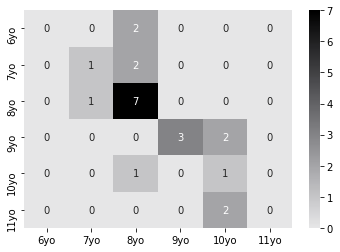

In [8]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
# /np.sum(cf_mat), fmt='.2%',
sns.heatmap(cf_mat, cmap=cmap, annot=True, xticklabels = ['6yo', '7yo', '8yo', '9yo', '10yo', '11yo'], yticklabels = ['6yo', '7yo', '8yo', '9yo', '10yo', '11yo'])

In [9]:
mean_error = (4+2+1+2+2+1+1)/22 #number of all tested videos
print(mean_error)

0.5909090909090909


# CSN age jog 

In [4]:
from mmcv import Config
cfg = Config.fromfile('mmaction2/configs/recognition/csn/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb.py')

In [5]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
# cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'age-gender-3split-rgb-frames/'
cfg.data_root_val = 'age-gender-3split-rgb-frames/val/'
cfg.ann_file_train = 'age-gender-3split-rgb-frames/childact_train_rgb320_age_jog.txt'
cfg.ann_file_val = 'age-gender-3split-rgb-frames/childact_val_rgb320_age_jog.txt'
cfg.ann_file_test = 'age-gender-3split-rgb-frames/childact_test_rgb320_age_jog.txt'

# cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'age-gender-3split-rgb-frames/childact_test_rgb320_age_jog.txt'
cfg.data.test.data_prefix = 'age-gender-3split-rgb-frames/test/'

# cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'age-gender-3split-rgb-frames/childact_train_rgb320_age_jog.txt'
cfg.data.train.data_prefix = 'age-gender-3split-rgb-frames/train/'

# cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'age-gender-3split-rgb-frames/childact_val_rgb320_age_jog.txt'
cfg.data.val.data_prefix = 'age-gender-3split-rgb-frames/val/'

# cfg.data.test.modality = 'Flow'
# cfg.data.val.modality = 'Flow'
# cfg.data.train.modality = 'Flow'

# cfg.data.train.start_index = 0
# cfg.data.test.start_index = 0
# cfg.data.val.start_index = 0

cfg.data.test.filename_tmpl = '{:03}.jpeg'
cfg.data.train.filename_tmpl = '{:03}.jpeg'
cfg.data.val.filename_tmpl = '{:03}.jpeg'
# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 6
# We can use the pre-trained TSN model
cfg.load_from = 'checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth'
# cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/CSN-age-jog'

cfg.total_epochs = 50

# cfg.momentum_config = dict(
#     policy='cyclic',
#     target_ratio=(0.85 / 0.95, 1),
#     cyclic_times=1,
#     step_ratio_up=0.4,
# )

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 20
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 100

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

cfg.data.videos_per_gpu=4

# cfg.model.backbone.in_channels = 2

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
# del cfg.optimizer['momentum']
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet3dCSN',
        pretrained2d=False,
        pretrained=
        'https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r152_ig65m_20200807-771c4135.pth',
        depth=152,
        with_pool2=False,
        bottleneck_mode='ir',
        norm_eval=True,
        zero_init_residual=False,
        bn_frozen=True),
    cls_head=dict(
        type='I3DHead',
        num_classes=6,
        in_channels=2048,
        spatial_type='avg',
        dropout_ratio=0.5,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
checkpoint_config = dict(interval=20)
log_config = dict(interval=100, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = 'checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth'
resume_from = None
workflow = [('train', 1)]
dataset_type = 'RawframeDataset

In [12]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
# CUDA_LAUNCH_BLOCKING=1
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-08-10 16:16:38,766 - mmaction - INFO - load model from: https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r152_ig65m_20200807-771c4135.pth
2021-08-10 16:16:38,767 - mmaction - INFO - Use load_from_http loader
2021-08-10 16:16:39,003 - mmaction - INFO - load checkpoint from checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth
2021-08-10 16:16:39,003 - mmaction - INFO - Use load_from_local loader
2021-08-10 16:16:39,149 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 2048]) from checkpoint, the shape in current model is torch.Size([6, 2048]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([6]).
2021-08-10 16:16:39,150 - mmaction - INFO - Start running, host: robt427nv@robt427NV, work_dir: /home/robt427nv/ch

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 15/15, 9.2 task/s, elapsed: 2s, ETA:     0s

2021-08-10 16:19:18,896 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 16:19:18,898 - mmaction - INFO - 
top1_acc	0.7333
top5_acc	1.0000
2021-08-10 16:19:18,899 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 16:19:18,900 - mmaction - INFO - 
mean_acc	0.3750
2021-08-10 16:19:19,209 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-08-10 16:19:19,210 - mmaction - INFO - Best top1_acc is 0.7333 at 5 epoch.
2021-08-10 16:19:19,210 - mmaction - INFO - Epoch(val) [5][4]	top1_acc: 0.7333, top5_acc: 1.0000, mean_class_accuracy: 0.3750


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 15/15, 9.7 task/s, elapsed: 2s, ETA:     0s

2021-08-10 16:22:00,722 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 16:22:00,724 - mmaction - INFO - 
top1_acc	0.6000
top5_acc	1.0000
2021-08-10 16:22:00,724 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 16:22:00,726 - mmaction - INFO - 
mean_acc	0.2250
2021-08-10 16:22:00,726 - mmaction - INFO - Epoch(val) [10][4]	top1_acc: 0.6000, top5_acc: 1.0000, mean_class_accuracy: 0.2250


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 15/15, 9.5 task/s, elapsed: 2s, ETA:     0s

2021-08-10 16:24:39,911 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 16:24:39,914 - mmaction - INFO - 
top1_acc	0.4000
top5_acc	1.0000
2021-08-10 16:24:39,914 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 16:24:39,917 - mmaction - INFO - 
mean_acc	0.2500
2021-08-10 16:24:39,918 - mmaction - INFO - Epoch(val) [15][4]	top1_acc: 0.4000, top5_acc: 1.0000, mean_class_accuracy: 0.2500
2021-08-10 16:27:12,426 - mmaction - INFO - Saving checkpoint at 20 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 15/15, 9.5 task/s, elapsed: 2s, ETA:     0s

2021-08-10 16:27:14,392 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 16:27:14,394 - mmaction - INFO - 
top1_acc	0.5333
top5_acc	1.0000
2021-08-10 16:27:14,394 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 16:27:14,396 - mmaction - INFO - 
mean_acc	0.3000
2021-08-10 16:27:14,396 - mmaction - INFO - Epoch(val) [20][4]	top1_acc: 0.5333, top5_acc: 1.0000, mean_class_accuracy: 0.3000


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 15/15, 9.8 task/s, elapsed: 2s, ETA:     0s

2021-08-10 16:29:49,037 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 16:29:49,039 - mmaction - INFO - 
top1_acc	0.6000
top5_acc	1.0000
2021-08-10 16:29:49,039 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 16:29:49,040 - mmaction - INFO - 
mean_acc	0.3250
2021-08-10 16:29:49,041 - mmaction - INFO - Epoch(val) [25][4]	top1_acc: 0.6000, top5_acc: 1.0000, mean_class_accuracy: 0.3250


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 15/15, 9.0 task/s, elapsed: 2s, ETA:     0s

2021-08-10 16:32:24,040 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 16:32:24,085 - mmaction - INFO - 
top1_acc	0.2667
top5_acc	1.0000
2021-08-10 16:32:24,103 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 16:32:24,196 - mmaction - INFO - 
mean_acc	0.4250
2021-08-10 16:32:24,237 - mmaction - INFO - Epoch(val) [30][4]	top1_acc: 0.2667, top5_acc: 1.0000, mean_class_accuracy: 0.4250


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 15/15, 9.6 task/s, elapsed: 2s, ETA:     0s

2021-08-10 16:34:59,790 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 16:34:59,792 - mmaction - INFO - 
top1_acc	0.4667
top5_acc	1.0000
2021-08-10 16:34:59,793 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 16:34:59,795 - mmaction - INFO - 
mean_acc	0.2750
2021-08-10 16:34:59,796 - mmaction - INFO - Epoch(val) [35][4]	top1_acc: 0.4667, top5_acc: 1.0000, mean_class_accuracy: 0.2750
2021-08-10 16:37:32,558 - mmaction - INFO - Saving checkpoint at 40 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 15/15, 9.2 task/s, elapsed: 2s, ETA:     0s

2021-08-10 16:37:34,605 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 16:37:34,606 - mmaction - INFO - 
top1_acc	0.4667
top5_acc	1.0000
2021-08-10 16:37:34,607 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 16:37:34,608 - mmaction - INFO - 
mean_acc	0.2750
2021-08-10 16:37:34,609 - mmaction - INFO - Epoch(val) [40][4]	top1_acc: 0.4667, top5_acc: 1.0000, mean_class_accuracy: 0.2750


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 15/15, 9.5 task/s, elapsed: 2s, ETA:     0s

2021-08-10 16:40:09,047 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 16:40:09,049 - mmaction - INFO - 
top1_acc	0.4667
top5_acc	1.0000
2021-08-10 16:40:09,049 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 16:40:09,050 - mmaction - INFO - 
mean_acc	0.2750
2021-08-10 16:40:09,051 - mmaction - INFO - Epoch(val) [45][4]	top1_acc: 0.4667, top5_acc: 1.0000, mean_class_accuracy: 0.2750
2021-08-10 16:42:41,388 - mmaction - INFO - Saving checkpoint at 50 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 15/15, 9.9 task/s, elapsed: 2s, ETA:     0s

2021-08-10 16:42:43,314 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-10 16:42:43,316 - mmaction - INFO - 
top1_acc	0.5333
top5_acc	1.0000
2021-08-10 16:42:43,317 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-10 16:42:43,319 - mmaction - INFO - 
mean_acc	0.5250
2021-08-10 16:42:43,320 - mmaction - INFO - Epoch(val) [50][4]	top1_acc: 0.5333, top5_acc: 1.0000, mean_class_accuracy: 0.5250


In [13]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

In [6]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model
import pickle
import mmcv
# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

model = pickle.load(open(f"{cfg.work_dir}/model50e", 'rb'))

2021-08-10 16:54:18,016 - mmaction - INFO - load model from: https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r152_ig65m_20200807-771c4135.pth
2021-08-10 16:54:18,017 - mmaction - INFO - Use load_from_http loader


In [7]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
# from mmaction.models import build_model
# from mmaction.datasets import build_dataset

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=1,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 0.6 task/s, elapsed: 17s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.4000
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.5000
top1_acc: 0.4000
top5_acc: 1.0000
mean_class_accuracy: 0.5000


<AxesSubplot:>

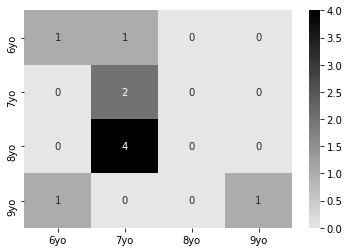

In [10]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
# /np.sum(cf_mat), fmt='.2%',
sns.heatmap(cf_mat, cmap=cmap, annot=True, xticklabels = ['6yo', '7yo', '8yo', '9yo'], yticklabels = ['6yo', '7yo', '8yo', '9yo'])

In [9]:
mean_error = (1+4+3)/10 #number of all tested videos
print(mean_error)

0.8


# CSN age run

In [2]:
cd /home/robt427nv/childact/

/home/robt427nv/childact


In [3]:
from mmcv import Config
cfg = Config.fromfile('mmaction2/configs/recognition/csn/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb.py')

In [5]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
# cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'age-gender-3split-rgb-frames/'
cfg.data_root_val = 'age-gender-3split-rgb-frames/val/'
cfg.ann_file_train = 'age-gender-3split-rgb-frames/childact_train_rgb320_age_run.txt'
cfg.ann_file_val = 'age-gender-3split-rgb-frames/childact_val_rgb320_age_run.txt'
cfg.ann_file_test = 'age-gender-3split-rgb-frames/childact_test_rgb320_age_run.txt'

# cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'age-gender-3split-rgb-frames/childact_test_rgb320_age_run.txt'
cfg.data.test.data_prefix = 'age-gender-3split-rgb-frames/test/'

# cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'age-gender-3split-rgb-frames/childact_train_rgb320_age_run.txt'
cfg.data.train.data_prefix = 'age-gender-3split-rgb-frames/train/'

# cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'age-gender-3split-rgb-frames/childact_val_rgb320_age_run.txt'
cfg.data.val.data_prefix = 'age-gender-3split-rgb-frames/val/'

# cfg.data.test.modality = 'Flow'
# cfg.data.val.modality = 'Flow'
# cfg.data.train.modality = 'Flow'

# cfg.data.train.start_index = 0
# cfg.data.test.start_index = 0
# cfg.data.val.start_index = 0

cfg.data.test.filename_tmpl = '{:03}.jpeg'
cfg.data.train.filename_tmpl = '{:03}.jpeg'
cfg.data.val.filename_tmpl = '{:03}.jpeg'
# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 6
# We can use the pre-trained TSN model
cfg.load_from = 'checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth'
# cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/CSN-age-run'

cfg.total_epochs = 50

# cfg.momentum_config = dict(
#     policy='cyclic',
#     target_ratio=(0.85 / 0.95, 1),
#     cyclic_times=1,
#     step_ratio_up=0.4,
# )

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 20
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 100

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

cfg.data.videos_per_gpu=6

# cfg.model.backbone.in_channels = 2

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
# del cfg.optimizer['momentum']
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet3dCSN',
        pretrained2d=False,
        pretrained=
        'https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r152_ig65m_20200807-771c4135.pth',
        depth=152,
        with_pool2=False,
        bottleneck_mode='ir',
        norm_eval=True,
        zero_init_residual=False,
        bn_frozen=True),
    cls_head=dict(
        type='I3DHead',
        num_classes=6,
        in_channels=2048,
        spatial_type='avg',
        dropout_ratio=0.5,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
checkpoint_config = dict(interval=20)
log_config = dict(interval=100, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = 'checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth'
resume_from = None
workflow = [('train', 1)]
dataset_type = 'RawframeDataset

In [6]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
# CUDA_LAUNCH_BLOCKING=1
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-08-23 00:04:56,437 - mmaction - INFO - load model from: https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r152_ig65m_20200807-771c4135.pth
2021-08-23 00:04:56,438 - mmaction - INFO - Use load_from_http loader
2021-08-23 00:04:58,498 - mmaction - INFO - load checkpoint from checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth
2021-08-23 00:04:58,499 - mmaction - INFO - Use load_from_local loader
2021-08-23 00:04:58,651 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 2048]) from checkpoint, the shape in current model is torch.Size([6, 2048]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([6]).
2021-08-23 00:04:58,657 - mmaction - INFO - Start running, host: robt427nv@robt427NV, work_dir: /home/robt427nv/ch

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 23/23, 10.9 task/s, elapsed: 2s, ETA:     0s

2021-08-23 00:06:56,485 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-23 00:06:56,488 - mmaction - INFO - 
top1_acc	0.3913
top5_acc	0.8696
2021-08-23 00:06:56,489 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-23 00:06:56,491 - mmaction - INFO - 
mean_acc	0.2000
2021-08-23 00:06:56,802 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-08-23 00:06:56,803 - mmaction - INFO - Best top1_acc is 0.3913 at 5 epoch.
2021-08-23 00:06:56,803 - mmaction - INFO - Epoch(val) [5][4]	top1_acc: 0.3913, top5_acc: 0.8696, mean_class_accuracy: 0.2000


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 23/23, 11.7 task/s, elapsed: 2s, ETA:     0s

2021-08-23 00:08:53,711 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-23 00:08:53,712 - mmaction - INFO - 
top1_acc	0.3478
top5_acc	0.8696
2021-08-23 00:08:53,713 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-23 00:08:53,714 - mmaction - INFO - 
mean_acc	0.1481
2021-08-23 00:08:53,715 - mmaction - INFO - Epoch(val) [10][4]	top1_acc: 0.3478, top5_acc: 0.8696, mean_class_accuracy: 0.1481


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 23/23, 11.3 task/s, elapsed: 2s, ETA:     0s

2021-08-23 00:10:50,507 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-23 00:10:50,509 - mmaction - INFO - 
top1_acc	0.4783
top5_acc	0.8696
2021-08-23 00:10:50,510 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-23 00:10:50,510 - mmaction - INFO - 
mean_acc	0.3156
2021-08-23 00:10:50,859 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_15.pth.
2021-08-23 00:10:50,860 - mmaction - INFO - Best top1_acc is 0.4783 at 15 epoch.
2021-08-23 00:10:50,860 - mmaction - INFO - Epoch(val) [15][4]	top1_acc: 0.4783, top5_acc: 0.8696, mean_class_accuracy: 0.3156
2021-08-23 00:12:45,802 - mmaction - INFO - Saving checkpoint at 20 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 23/23, 11.1 task/s, elapsed: 2s, ETA:     0s

2021-08-23 00:12:48,284 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-23 00:12:48,286 - mmaction - INFO - 
top1_acc	0.3043
top5_acc	0.8696
2021-08-23 00:12:48,286 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-23 00:12:48,287 - mmaction - INFO - 
mean_acc	0.2185
2021-08-23 00:12:48,287 - mmaction - INFO - Epoch(val) [20][4]	top1_acc: 0.3043, top5_acc: 0.8696, mean_class_accuracy: 0.2185


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 23/23, 11.4 task/s, elapsed: 2s, ETA:     0s

2021-08-23 00:14:45,022 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-23 00:14:45,024 - mmaction - INFO - 
top1_acc	0.3478
top5_acc	0.8696
2021-08-23 00:14:45,024 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-23 00:14:45,025 - mmaction - INFO - 
mean_acc	0.1778
2021-08-23 00:14:45,026 - mmaction - INFO - Epoch(val) [25][4]	top1_acc: 0.3478, top5_acc: 0.8696, mean_class_accuracy: 0.1778


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 23/23, 11.5 task/s, elapsed: 2s, ETA:     0s

2021-08-23 00:16:41,882 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-23 00:16:41,884 - mmaction - INFO - 
top1_acc	0.3913
top5_acc	0.8696
2021-08-23 00:16:41,885 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-23 00:16:41,886 - mmaction - INFO - 
mean_acc	0.1963
2021-08-23 00:16:41,886 - mmaction - INFO - Epoch(val) [30][4]	top1_acc: 0.3913, top5_acc: 0.8696, mean_class_accuracy: 0.1963


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 23/23, 11.5 task/s, elapsed: 2s, ETA:     0s

2021-08-23 00:18:38,544 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-23 00:18:38,545 - mmaction - INFO - 
top1_acc	0.3913
top5_acc	0.8696
2021-08-23 00:18:38,546 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-23 00:18:38,547 - mmaction - INFO - 
mean_acc	0.2259
2021-08-23 00:18:38,548 - mmaction - INFO - Epoch(val) [35][4]	top1_acc: 0.3913, top5_acc: 0.8696, mean_class_accuracy: 0.2259
2021-08-23 00:20:33,574 - mmaction - INFO - Saving checkpoint at 40 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 23/23, 11.3 task/s, elapsed: 2s, ETA:     0s

2021-08-23 00:20:36,022 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-23 00:20:36,023 - mmaction - INFO - 
top1_acc	0.4348
top5_acc	0.8696
2021-08-23 00:20:36,023 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-23 00:20:36,024 - mmaction - INFO - 
mean_acc	0.3111
2021-08-23 00:20:36,024 - mmaction - INFO - Epoch(val) [40][4]	top1_acc: 0.4348, top5_acc: 0.8696, mean_class_accuracy: 0.3111


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 23/23, 11.2 task/s, elapsed: 2s, ETA:     0s

2021-08-23 00:22:32,715 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-23 00:22:32,717 - mmaction - INFO - 
top1_acc	0.3913
top5_acc	0.8696
2021-08-23 00:22:32,717 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-23 00:22:32,718 - mmaction - INFO - 
mean_acc	0.2711
2021-08-23 00:22:32,719 - mmaction - INFO - Epoch(val) [45][4]	top1_acc: 0.3913, top5_acc: 0.8696, mean_class_accuracy: 0.2711
2021-08-23 00:24:27,755 - mmaction - INFO - Saving checkpoint at 50 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 23/23, 10.6 task/s, elapsed: 2s, ETA:     0s

2021-08-23 00:24:30,351 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-08-23 00:24:30,354 - mmaction - INFO - 
top1_acc	0.3913
top5_acc	0.8696
2021-08-23 00:24:30,354 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-08-23 00:24:30,356 - mmaction - INFO - 
mean_acc	0.2259
2021-08-23 00:24:30,357 - mmaction - INFO - Epoch(val) [50][4]	top1_acc: 0.3913, top5_acc: 0.8696, mean_class_accuracy: 0.2259


In [7]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

In [6]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model
import pickle
import mmcv
# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

model = pickle.load(open(f"{cfg.work_dir}/model50e", 'rb'))

2021-08-10 16:54:18,016 - mmaction - INFO - load model from: https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r152_ig65m_20200807-771c4135.pth
2021-08-10 16:54:18,017 - mmaction - INFO - Use load_from_http loader


In [8]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
# from mmaction.models import build_model
# from mmaction.datasets import build_dataset

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=1,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 26/26, 0.6 task/s, elapsed: 42s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5000
top5_acc	0.9615

Evaluating mean_class_accuracy ...

mean_acc	0.4048
top1_acc: 0.5000
top5_acc: 0.9615
mean_class_accuracy: 0.4048


<AxesSubplot:>

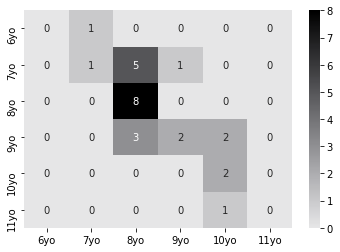

In [12]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
# /np.sum(cf_mat), fmt='.2%',
sns.heatmap(cf_mat, cmap=cmap, annot=True, xticklabels = ['6yo', '7yo', '8yo', '9yo', '10yo', '11yo'], yticklabels = ['6yo', '7yo', '8yo', '9yo', '10yo', '11yo'])
# sns.heatmap(cf_mat, cmap=cmap, annot=True, xticklabels = ['7yo', '8yo', '9yo', '10yo'], yticklabels = ['7yo', '8yo', '9yo', '10yo'])

In [13]:
mean_error = (1+5+2+5+1)/26 #number of all tested videos
print(mean_error)

0.5384615384615384
